## Extracción de tópicos con LDA
Notebook para sacar los tópicos principales del conjunto total de documentos utilizando el modelo LDA. 

### Índice
1. Carga del dataset
2. Limpieza del dataset (tonkenización y lematización)
3. Modelado de tópicos
4. Dataset final

### Librerías

In [2]:
# Librerías para cargar los archivos
import os
import re
import glob
from pathlib import Path
import pypdf
import PyPDF2

# Librerías comunes
import pandas as pd
import numpy as np

# 1. Carga y estructuración del dataset

In [3]:
'''
discursos_folder = 'discursos/tfm'
texto_discursos = []
fechas = []
personas = []

# Nombres de las personas buscadas
nombres_personas = ['bernanke', 'yellen', 'powell', 'waller', 'jefferson', 'cook', 'bowman', 'barr']

# Itera a través de cada archivo en la carpeta
for archivo_nombre in os.listdir(discursos_folder):
    if archivo_nombre.endswith('.pdf'):
        # Extraer la fecha del nombre del archivo
        fecha_match = re.search(r'(\d{4})(\d{2})(\d{2})', archivo_nombre)
        if fecha_match:
            año, mes, dia = fecha_match.groups()
            fecha = f'{año}-{mes}-{dia}'
            fechas.append(fecha)
        
       # Buscar el nombre de la persona en el nombre del archivo
        persona = None
        for nombre in nombres_personas:
            if nombre in archivo_nombre.lower():
                persona = nombre
                break
        
        personas.append(persona)
        
        # Construye la ruta completa del archivo
        archivo_ruta = os.path.join(discursos_folder, archivo_nombre)
        
        # Abre el archivo PDF en modo de lectura binaria
        with open(archivo_ruta, 'rb') as archivo_pdf:
            # Crea un objeto PDFReader
            lector_pdf = PyPDF2.PdfReader(archivo_pdf)
            
            # Itera a través de cada página y extrae el texto
            texto_archivo = ''
            for pagina in lector_pdf.pages:
                texto_archivo += pagina.extract_text()

            # Agrega el texto del archivo a la lista de discursos
            texto_discursos.append(texto_archivo)

# Crear DataFrame
data = {'texto': texto_discursos, 'fecha': fechas, 'persona': personas}
df = pd.DataFrame(data)

df.head(2)
'''

"\ndiscursos_folder = 'discursos/tfm'\ntexto_discursos = []\nfechas = []\npersonas = []\n\n# Nombres de las personas buscadas\nnombres_personas = ['bernanke', 'yellen', 'powell', 'waller', 'jefferson', 'cook', 'bowman', 'barr']\n\n# Itera a través de cada archivo en la carpeta\nfor archivo_nombre in os.listdir(discursos_folder):\n    if archivo_nombre.endswith('.pdf'):\n        # Extraer la fecha del nombre del archivo\n        fecha_match = re.search(r'(\\d{4})(\\d{2})(\\d{2})', archivo_nombre)\n        if fecha_match:\n            año, mes, dia = fecha_match.groups()\n            fecha = f'{año}-{mes}-{dia}'\n            fechas.append(fecha)\n        \n       # Buscar el nombre de la persona en el nombre del archivo\n        persona = None\n        for nombre in nombres_personas:\n            if nombre in archivo_nombre.lower():\n                persona = nombre\n                break\n        \n        personas.append(persona)\n        \n        # Construye la ruta completa del arch

In [4]:
#Para ahorrar tiempo empezamos a ejecutar desde esta linea, que es el dataset anterior guardado: 
#df.to_csv('dataset_cargado.csv', index=False)
df = pd.read_csv('dataset_cargado.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   texto    198 non-null    object
 1   fecha    198 non-null    object
 2   persona  198 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB


In [6]:
#Limpiamos los textos
df.replace('\n', '', regex=True, inplace=True)
pd.set_option('display.max_colwidth', 200)

#Añadimos una columna con solo el año y reorganizamos el dataset: 
df['fecha'] = pd.to_datetime(df['fecha'])
df['year'] = df['fecha'].dt.year
df= df[['texto', 'persona', 'fecha', 'year']]

#Eliminamos 2024 del conjunto de datos
df = df[df['year'] != 2024]

df.info(),
df.head(2)


<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 0 to 197
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   texto    197 non-null    object        
 1   persona  197 non-null    object        
 2   fecha    197 non-null    datetime64[ns]
 3   year     197 non-null    int32         
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 6.9+ KB


,texto,persona,fecha,year
0,"For release on delivery 12:30 p.m. EDT July 10, 2015 Recent Developments and the Outlook for the Economy Remarks by Janet L. Yellen Chair Board of Governors of the...",yellen,2015-07-10,2015
1,"For release on delivery 7:15 p.m. E DT (4:15 p.m. PDT) May 6, 2022 Reflections on Monetary Policy in 2021 Remarks by Christopher J. Waller Member Board of Governors of the Fe...",waller,2022-05-06,2022


# 2. Limpieza del dataset

## Tonkenización

In [7]:
import spacy

# Librerías para LDA
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt

In [8]:
#Paso 1: limpiamos el texto
def clean_text(text):
    # Eliminar URLs
    text_no_urls = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Eliminar caracteres no alfabéticos
    text_alpha = re.sub('[^a-zA-Z]', ' ', text_no_urls)
    # Pasar a minúsculas y eliminar espacios adicionales
    return ' '.join(text_alpha.lower().split())

df['texto_limpio'] = df['texto'].apply(clean_text)

# Paso 2: Tokenizar el texto limpio
tokens = [t.split() for t in df['texto_limpio']]

# Paso 3: Eliminar stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])
df['sin_stopwords'] = df['texto_limpio'].apply(remove_stopwords)
df.head(2)


,texto,persona,fecha,year,texto_limpio,sin_stopwords
0,"For release on delivery 12:30 p.m. EDT July 10, 2015 Recent Developments and the Outlook for the Economy Remarks by Janet L. Yellen Chair Board of Governors of the...",yellen,2015-07-10,2015,for release on delivery p m edt july recent developments and the outlook for the economy remarks by janet l yellen chair board of governors of the federal reserve system at the city club of clevel...,release delivery p m edt july recent developments outlook economy remarks janet l yellen chair board governors federal reserve city club cleveland cleveland ohio july thank president mester thank ...
1,"For release on delivery 7:15 p.m. E DT (4:15 p.m. PDT) May 6, 2022 Reflections on Monetary Policy in 2021 Remarks by Christopher J. Waller Member Board of Governors of the Fe...",waller,2022-05-06,2022,for release on delivery p m e dt p m pdt may reflections on monetary policy in remarks by christopher j waller member board of governors of the federal reserve system at how monetary policy got be...,release delivery p m e dt p m pdt reflections monetary policy remarks christopher j waller member board governors federal reserve monetary policy got curve policy conference hoover institution sta...


In [9]:
from collections import Counter

# Función para filtrar palabras de una sola letra
def filter_one_letter_words(text):
    return [word for word in text.split() if len(word) > 1]

# Contar la frecuencia de las palabras en cada documento
word_counts_per_doc = [Counter(filter_one_letter_words(doc)) for doc in df['sin_stopwords']]

# Obtener las 5 palabras más repetidas por documento
top_words_per_doc = [[word for word, _ in doc.most_common(5)] for doc in word_counts_per_doc]

# Crear un DataFrame para mostrar los resultados
top_words_df = pd.DataFrame({'Top 5 palabras': top_words_per_doc})
top_words_df.index.name = 'Documento'

# Mostrar el DataFrame resultante
print(top_words_df) 

                                                  Top 5 palabras
Documento                                                       
0                   [economic, federal, inflation, rate, growth]
1                   [policy, inflation, market, labor, tapering]
2                     [banks, community, reserve, federal, bank]
3                       [inflation, year, policy, labor, market]
4                       [mexico, united, states, agust, chamber]
...                                                          ...
192        [diversity, economics, economists, profession, board]
193             [financial, stability, crisis, market, economic]
194              [economic, economy, powers, financial, support]
195                     [inflation, rate, percent, policy, year]
196             [inflation, rate, policy, federal, unemployment]

[197 rows x 1 columns]


Analizando los bigramas resultantes de los lemmas me he dado cuenta que el que más aparece en el corpus es feceral reserve, no porque sea relevante sino porque es la institución de la cual sacamos los documentos. Por lo tanto, para una relevante selección de tópicos eliminaré ambas palabras del corpus. 

![Imagen](bigramas-corpus.png)

In [10]:
def eliminar_federal_reserve(texto):
    return texto.replace('federal reserve', '').replace('Federal Reserve', '')

# Aplica la función a la columna 'texto_limpio' y crea una nueva columna llamada 'sin_federal_reserve'
df['sin_stopwords'] = df['sin_stopwords'].apply(eliminar_federal_reserve)

## Lematización

In [11]:
#Mostrar la barra de proceso con esta librería
from tqdm import tqdm
tqdm.pandas()

In [13]:
nlp = spacy.load("en_core_web_lg")
df['lemmas'] = df['sin_stopwords'].progress_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True) and (len(token) > 2)])
df.head(2)

100%|██████████| 197/197 [00:39<00:00,  4.97it/s]


,texto,persona,fecha,year,texto_limpio,sin_stopwords,lemmas
0,"For release on delivery 12:30 p.m. EDT July 10, 2015 Recent Developments and the Outlook for the Economy Remarks by Janet L. Yellen Chair Board of Governors of the...",yellen,2015-07-10,2015,for release on delivery p m edt july recent developments and the outlook for the economy remarks by janet l yellen chair board of governors of the federal reserve system at the city club of clevel...,release delivery p m edt july recent developments outlook economy remarks janet l yellen chair board governors city club cleveland cleveland ohio july thank president mester thank city club invit...,"[release, delivery, edt, july, recent, development, outlook, economy, remark, janet, yellen, chair, board, governor, city, club, cleveland, cleveland, ohio, july, thank, president, mester, thank, ..."
1,"For release on delivery 7:15 p.m. E DT (4:15 p.m. PDT) May 6, 2022 Reflections on Monetary Policy in 2021 Remarks by Christopher J. Waller Member Board of Governors of the Fe...",waller,2022-05-06,2022,for release on delivery p m e dt p m pdt may reflections on monetary policy in remarks by christopher j waller member board of governors of the federal reserve system at how monetary policy got be...,release delivery p m e dt p m pdt reflections monetary policy remarks christopher j waller member board governors monetary policy got curve policy conference hoover institution stanford californi...,"[release, delivery, pdt, reflection, monetary, policy, remark, christopher, waller, member, board, governor, monetary, policy, get, curve, policy, conference, hoover, institution, stanford, califo..."


In [ ]:
df.to_csv('df_lemmas.csv', index=False)

In [ ]:
df = pd.read_csv('df_lemmas.csv')
 #como se guarda se necesita pasar la columna de texto a lista de palabras df['lemmas'] = df['lemmas'].apply(lambda x: eval(x))

# 3. Modelado de tópicos

## Bag of words

In [16]:
#Diccionario de todas las palabras
id2word = corpora.Dictionary(df['lemmas'])
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

## Latent Dirichlet Allocation (LDA)

###  Buscar el número de tópicos ideal

In [ ]:
#Obtener el número óptimo de topics 

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics,
                                                        chunksize=90,
                                                        passes=20,
                                                        per_word_topics=True,
                                                        workers=12)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [ ]:

%%time
# Apply our function
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=df['lemmas'], 
                                                        start=2, 
                                                        limit=20, 
                                                        step=2)
                                                     


CPU times: user 2min 6s, sys: 18.1 s, total: 2min 24s
Wall time: 3min 3s


In [ ]:
coherence_values

[0.41124920727278014,
 0.4251268389490872,
 0.43007824420340884,
 0.47780151934562476,
 0.43481650103617114,
 0.4351555375387999,
 0.4367635539676725,
 0.4387677530858136,
 0.4498273134644587]

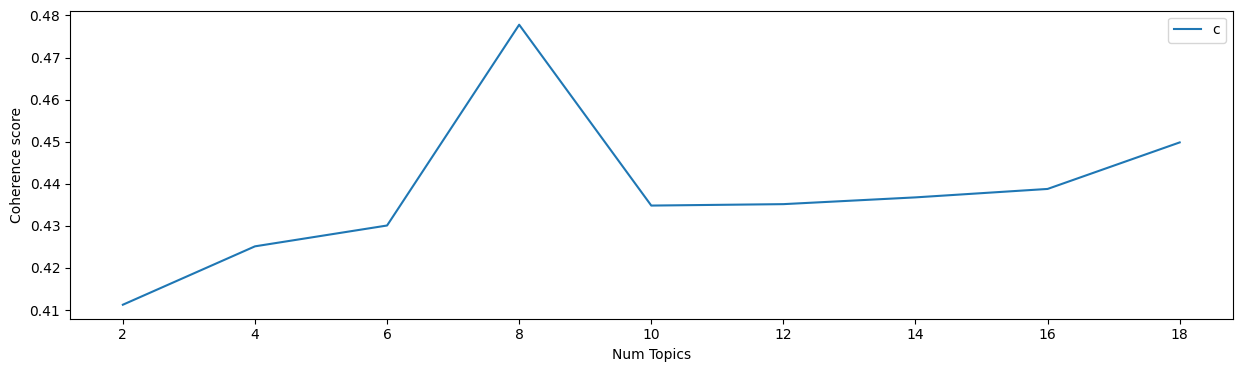

In [ ]:

limit=20; start=2; step=2;
x = range(start, limit, step)
plt.figure(figsize=(15, 4))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [ ]:

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " consists of a Coherence Value of", round(cv, 4))



Num Topics = 2  consists of a Coherence Value of 0.4112
Num Topics = 4  consists of a Coherence Value of 0.4251
Num Topics = 6  consists of a Coherence Value of 0.4301
Num Topics = 8  consists of a Coherence Value of 0.4778
Num Topics = 10  consists of a Coherence Value of 0.4348
Num Topics = 12  consists of a Coherence Value of 0.4352
Num Topics = 14  consists of a Coherence Value of 0.4368
Num Topics = 16  consists of a Coherence Value of 0.4388
Num Topics = 18  consists of a Coherence Value of 0.4498


Aunque los niveles de coherencia son más altos con 8 temas, para el estudio que queremos hacer necesita ser más reducido, por lo que selecionaremos 5 tópicos

### LDA con 5 tópicos

In [17]:
#%%time
lda_k5= gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        random_state=42,
                                                        num_topics=5, 
                                                        chunksize=90,
                                                        passes=20,
                                                        per_word_topics=True,
                                                        workers=12
                                                        )


lda_k5.save('topicos5.model')

In [18]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_k5.print_topics()]
topics = [' '.join(t[0:5]) for t in words]
topics

['inflation rate policy percent economic',
 'financial bank risk market firm',
 'policy financial rate monetary term',
 'economic work woman economy education',
 'bank community business banking financial']

In [ ]:
# Vamos a ver cómo de separados estan nuestros temas entre si
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_k5, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.118990  0.030869       1        1  41.449135
2      0.033772  0.085579       2        1  19.822718
1     -0.100734  0.048832       3        1  15.274025
4     -0.102094 -0.043577       4        1  13.574084
3      0.050066 -0.121703       5        1   9.880038, topic_info=           Term         Freq        Total Category  logprob  loglift
65         bank  2824.000000  2824.000000  Default  30.0000  30.0000
1204  community  1181.000000  1181.000000  Default  29.0000  29.0000
285   financial  2548.000000  2548.000000  Default  28.0000  28.0000
382   inflation  2740.000000  2740.000000  Default  27.0000  27.0000
580      policy  3042.000000  3042.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
580      policy   117.888949  3042.996976   Topic5  -5.5155  -0.9362
843         vol    82.847895   421.060278   Topic5  -5.8682   0.6889
74        board    92.157257  1001.629296   Topic5  -5.7617  -0.0712
875        year    97.399247  1803.839502   Topic5  -5.7064  -0.6042
805        time    90.213886  1259.192935   Topic5  -5.7830  -0.3214

[445 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
3676      2  0.816634  accountability
3676      3  0.020939  accountability
3676      4  0.125636  accountability
5268      3  0.922362       activitie
9379      3  0.921573             aig
...     ...       ...             ...
1119      5  0.017955           yield
878       1  0.264654           young
878       3  0.025205           young
878       4  0.050410           young
878       5  0.655333           young

[1106 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])

In [19]:
#Importancia de cada tópico
def document_to_lda_features(lda_k5,document):
  topic_importance=np.array(lda_k5.get_document_topics(document, minimum_probability=0))
  return topic_importance[:,1]

#Buscar el topico predominante en cada documento
df['lda_features']=list(map(lambda doc: document_to_lda_features(lda_k5,doc), corpus))

In [20]:
def topic_important(item_score):
    score=np.argmax(item_score, axis=0)
    return score

# Apply tokenizer
df['topic_dominant'] = df['lda_features'].apply(topic_important)
df.head(2)

,texto,persona,fecha,year,texto_limpio,sin_stopwords,lemmas,lda_features,topic_dominant
0,"For release on delivery 12:30 p.m. EDT July 10, 2015 Recent Developments and the Outlook for the Economy Remarks by Janet L. Yellen Chair Board of Governors of the...",yellen,2015-07-10,2015,for release on delivery p m edt july recent developments and the outlook for the economy remarks by janet l yellen chair board of governors of the federal reserve system at the city club of clevel...,release delivery p m edt july recent developments outlook economy remarks janet l yellen chair board governors city club cleveland cleveland ohio july thank president mester thank city club invit...,"[release, delivery, edt, july, recent, development, outlook, economy, remark, janet, yellen, chair, board, governor, city, club, cleveland, cleveland, ohio, july, thank, president, mester, thank, ...","[0.9977643489837646, 9.247767593478784e-05, 0.001957839820533991, 9.28225417737849e-05, 9.255873010260984e-05]",0
1,"For release on delivery 7:15 p.m. E DT (4:15 p.m. PDT) May 6, 2022 Reflections on Monetary Policy in 2021 Remarks by Christopher J. Waller Member Board of Governors of the Fe...",waller,2022-05-06,2022,for release on delivery p m e dt p m pdt may reflections on monetary policy in remarks by christopher j waller member board of governors of the federal reserve system at how monetary policy got be...,release delivery p m e dt p m pdt reflections monetary policy remarks christopher j waller member board governors monetary policy got curve policy conference hoover institution stanford californi...,"[release, delivery, pdt, reflection, monetary, policy, remark, christopher, waller, member, board, governor, monetary, policy, get, curve, policy, conference, hoover, institution, stanford, califo...","[0.9992947578430176, 0.0001750125811668113, 0.00018187302339356393, 0.00017349922563880682, 0.00017483999545220286]",0


In [21]:
# Número de documentos asociados a cada tópico
df["topic_dominant"].value_counts()

topic_dominant
0    63
4    42
2    34
1    33
3    25
Name: count, dtype: int64

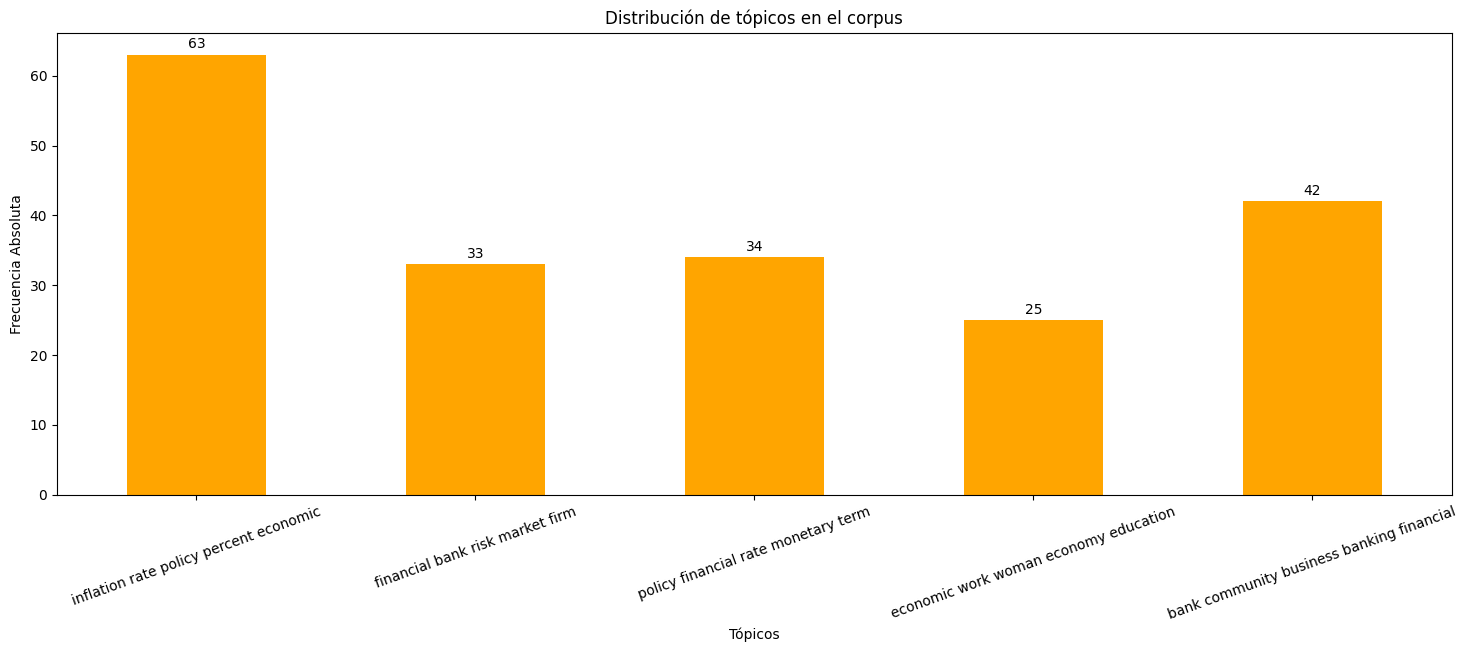

: 

In [37]:
plt.figure(figsize=(18, 6))
ax=df["topic_dominant"].value_counts().sort_index().plot(kind='bar', color ='orange')
plt.ylabel('Frecuencia Absoluta')
plt.xlabel('Tópicos')
plt.title('Distribución de tópicos en el corpus')
totals = df["topic_dominant"].value_counts().sort_index()
for i, total in enumerate(totals):
    ax.text(i, total + 0.5, str(total), ha='center', va='bottom')
topics= {
    0: 'inflation rate policy percent economic',
    1: 'financial bank risk market firm',
    2: 'policy financial rate monetary term',
    3: 'economic work woman economy education',
    4: 'bank community business banking financial'
}
ax.set_xticklabels([topics[i] for i in range(len(topics))], rotation=20)
plt.show()

# 6. Dataset final

In [ ]:
topic_names = ['topic_{}'.format(i) for i in range(5)]

# Crear nuevas columnas para cada tema
for i, topic in enumerate(topic_names):
    df[topic] = df['lda_features'].apply(lambda x: x[i])

df.drop(['texto_limpio','sin_stopwords','lda_features'], axis=1, inplace=True)

In [ ]:
df.head(2)

,texto,persona,fecha,year,lemmas,topic_dominant,topic_0,topic_1,topic_2,topic_3,topic_4
0,"For release on delivery 12:30 p.m. EDT July 10, 2015 Recent Developments and the Outlook for the Economy Remarks by Janet L. Yellen Chair Board of Governors of the...",yellen,2015-07-10,2015,"[release, delivery, edt, july, recent, development, outlook, economy, remark, janet, yellen, chair, board, governor, city, club, cleveland, cleveland, ohio, july, thank, president, mester, thank, ...",0,0.997907,0.000092,0.001816,0.000093,0.000093
1,"For release on delivery 7:15 p.m. E DT (4:15 p.m. PDT) May 6, 2022 Reflections on Monetary Policy in 2021 Remarks by Christopher J. Waller Member Board of Governors of the Fe...",waller,2022-05-06,2022,"[release, delivery, pdt, reflection, monetary, policy, remark, christopher, waller, member, board, governor, monetary, policy, get, curve, policy, conference, hoover, institution, stanford, califo...",0,0.999300,0.000175,0.000177,0.000173,0.000175


In [ ]:
df.to_csv('dataset_final.csv', index=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 0 to 197
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   texto           197 non-null    object        
 1   persona         197 non-null    object        
 2   fecha           197 non-null    datetime64[ns]
 3   year            197 non-null    int32         
 4   lemmas          197 non-null    object        
 5   topic_dominant  197 non-null    int64         
 6   topic_0         197 non-null    float64       
 7   topic_1         197 non-null    float64       
 8   topic_2         197 non-null    float64       
 9   topic_3         197 non-null    float64       
 10  topic_4         197 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int32(1), int64(1), object(3)
memory usage: 17.7+ KB


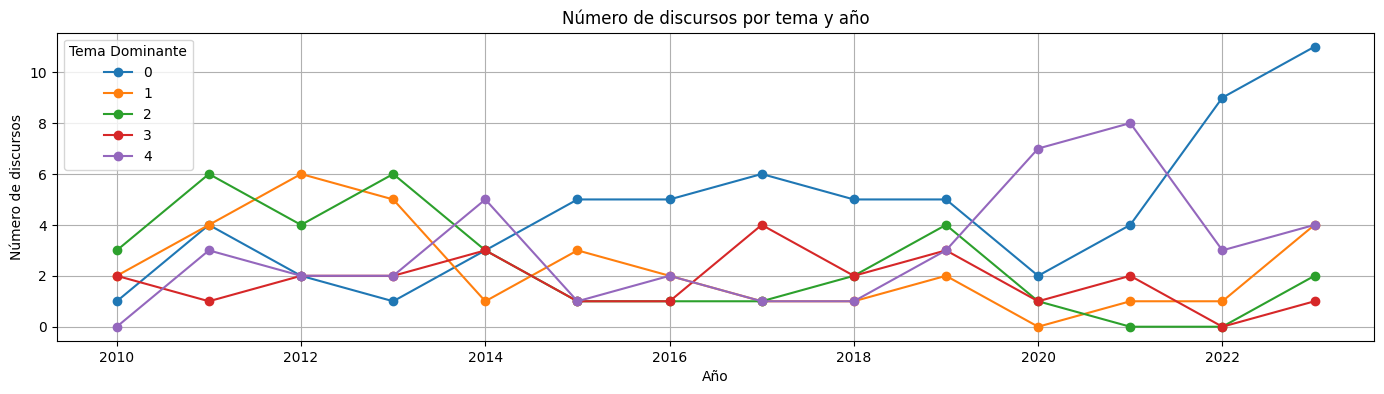

In [ ]:
pivot_df = df.pivot_table(index='year', columns='topic_dominant', values='texto', aggfunc='count', fill_value=0)

# Graficar
pivot_df.plot(kind='line', marker='o', figsize=(17, 4))
plt.title('Número de discursos por tema y año')
plt.xlabel('Año')
plt.ylabel('Número de discursos')
plt.legend(title='Tema Dominante')
plt.grid(True)
plt.show()

In [ ]:
topics

['inflation rate policy percent economic',
 'financial bank risk market firm',
 'policy financial rate monetary term',
 'economic work woman economy education',
 'bank community business banking financial']

# WORD CLOUD

In [ ]:
from wordcloud import WordCloud

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(10, 7))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [ ]:
# Generate word cloud
text = ' '.join([' '.join(lemmas) for lemmas in df['lemmas']])
wordcloud = WordCloud(width=3000, height=2000, random_state=1, background_color='white', colormap='Set2', collocations=False).generate(text)

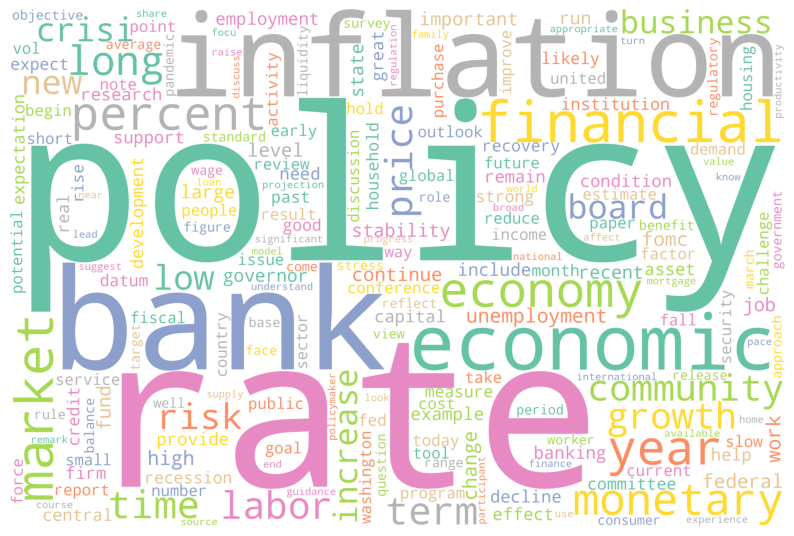

In [ ]:
plot_cloud(wordcloud) 